# Python libraries

In [2]:
# Libraries
import ee
import geemap
import os
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.exposure import match_histograms
import time
import texttable as tt
import rasterio
from rasterio.plot import reshape_as_raster

# Import images
In the following cell the images are imported, each band as a TIFF file.

Following, metadata of the bands are displayed and the bands are concatenated as a image.

In [3]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')

# Landsat8 bands path
landsat_b2 = os.path.join(out_dir, 'landsat_multi_sr_resized_B2.tif')
landsat_b3 = os.path.join(out_dir, 'landsat_multi_sr_resized_B3.tif')
landsat_b4 = os.path.join(out_dir, 'landsat_multi_sr_resized_B4.tif')

# Sentinel2 bands path
sentinel_b2 = os.path.join(out_dir, 'sentinel_multi_sr.B2.tif')
sentinel_b3 = os.path.join(out_dir, 'sentinel_multi_sr.B3.tif')
sentinel_b4 = os.path.join(out_dir, 'sentinel_multi_sr.B4.tif')

# Landsat8 bands
r_landsat_B2 = rasterio.open(landsat_b2)
r_landsat_B3 = rasterio.open(landsat_b3)
r_landsat_B4 = rasterio.open(landsat_b4)
img_landsat_B2 = r_landsat_B2.read(1)
img_landsat_B3 = r_landsat_B3.read(1)
img_landsat_B4 = r_landsat_B4.read(1)

# Landsat8 bands
r_sentinel_B2 = rasterio.open(sentinel_b2)
r_sentinel_B3 = rasterio.open(sentinel_b3)
r_sentinel_B4 = rasterio.open(sentinel_b4)
img_sentinel_B2 = r_sentinel_B2.read(1)
img_sentinel_B3 = r_sentinel_B3.read(1)
img_sentinel_B4 = r_sentinel_B4.read(1)

# Metadata about the TIFF
print('Landsat 8 -> band 2 shape:',img_landsat_B2.shape, '| Range (min, max): (', np.amin(img_landsat_B2), ',', np.amax(img_landsat_B2), ') | Data type: ', img_landsat_B2.dtype)
print('Landsat 8 -> band 3 shape:',img_landsat_B3.shape, '| Range (min, max): (', np.amin(img_landsat_B3), ',', np.amax(img_landsat_B3), ') | Data type: ', img_landsat_B3.dtype)
print('Landsat 8 -> band 4 shape:',img_landsat_B4.shape, '| Range (min, max): (', np.amin(img_landsat_B4), ',', np.amax(img_landsat_B4), ') | Data type: ', img_landsat_B4.dtype)
print()
print('Sentinel 2 -> band 2 shape:',img_sentinel_B2.shape, '| Range (min, max): (', np.amin(img_sentinel_B2), ',', np.amax(img_sentinel_B2), ') | Data type: ', img_sentinel_B2.dtype)
print('Sentinel 2 -> band 2 shape:',img_sentinel_B3.shape, '| Range (min, max): (', np.amin(img_sentinel_B3), ',', np.amax(img_sentinel_B3), ') | Data type: ', img_sentinel_B3.dtype)
print('Sentinel 2 -> band 2 shape:',img_sentinel_B4.shape, '| Range (min, max): (', np.amin(img_sentinel_B4), ',', np.amax(img_sentinel_B4), ') | Data type: ', img_sentinel_B4.dtype)

# Concatenate the bands of the Landsat 8 image into a single numpy array
L8_R = np.expand_dims(img_landsat_B4, axis=2)
L8_G = np.expand_dims(img_landsat_B3, axis=2)
L8_B = np.expand_dims(img_landsat_B2, axis=2)

# Concatenate the bands of the Sentinel 2 image into a single numpy array
S2_R = np.expand_dims(img_sentinel_B4, axis=2)
S2_G = np.expand_dims(img_sentinel_B3, axis=2)
S2_B = np.expand_dims(img_sentinel_B2, axis=2)

img_L8_xs = np.concatenate((L8_R,L8_G), axis=2)
img_L8_xs = np.concatenate((img_L8_xs,L8_B), axis=2)
print('Landsat image shape: ', img_L8_xs.shape)

img_S2_xs = np.concatenate((S2_R,S2_G), axis=2)
img_S2_xs = np.concatenate((img_S2_xs,S2_B), axis=2)
print('Sentinel image shape: ', img_S2_xs.shape)

Landsat 8 -> band 2 shape: (210, 539) | Range (min, max): ( 309 , 3354 ) | Data type:  uint16
Landsat 8 -> band 3 shape: (210, 539) | Range (min, max): ( 503 , 3949 ) | Data type:  uint16
Landsat 8 -> band 4 shape: (210, 539) | Range (min, max): ( 294 , 4358 ) | Data type:  uint16

Sentinel 2 -> band 2 shape: (210, 539) | Range (min, max): ( 287 , 7222 ) | Data type:  uint16
Sentinel 2 -> band 2 shape: (210, 539) | Range (min, max): ( 476 , 8581 ) | Data type:  uint16
Sentinel 2 -> band 2 shape: (210, 539) | Range (min, max): ( 285 , 10672 ) | Data type:  uint16
Landsat image shape:  (210, 539, 3)
Sentinel image shape:  (210, 539, 3)


# Histogram matching
Match the histogram of Sentinel 2 image to the histogram of Landsat 8, in order to select the spectral quality of Landsat 8.

In [4]:
matched = match_histograms(img_S2_xs, img_L8_xs, multichannel=True)

# Image visualization
Before showing the images, we have to normalize them to the range 0-255, in order to display them in RGB color space

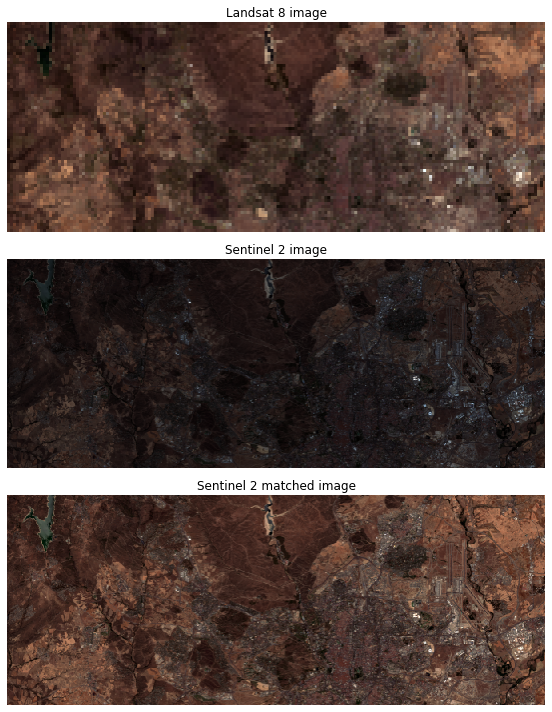

In [5]:
# Landsat 8 image normalization
L8_Rv = (((L8_R-np.amin(L8_R))/(np.amax(L8_R)-np.amin(L8_R)))*255).astype(int)
L8_Gv = (((L8_G-np.amin(L8_G))/(np.amax(L8_G)-np.amin(L8_G)))*255).astype(int)
L8_Bv = (((L8_B-np.amin(L8_B))/(np.amax(L8_B)-np.amin(L8_B)))*255).astype(int)
L8_xs = np.concatenate((L8_Rv,L8_Gv), axis=2)
L8_xs = np.concatenate((L8_xs,L8_Bv), axis=2)

# Sentinel 2 image normalization
S2_Rv = (((S2_R-np.amin(S2_R))/(np.amax(S2_R)-np.amin(S2_R)))*255).astype(int)
S2_Gv = (((S2_G-np.amin(S2_G))/(np.amax(S2_G)-np.amin(S2_G)))*255).astype(int)
S2_Bv = (((S2_B-np.amin(S2_B))/(np.amax(S2_B)-np.amin(S2_B)))*255).astype(int)
S2_xs = np.concatenate((S2_Rv,S2_Gv), axis=2)
S2_xs = np.concatenate((S2_xs,S2_Bv), axis=2)

# Sentinel 2 matched image normalization
S2_RvM = (((matched[:,:,0]-np.amin(matched[:,:,0]))/(np.amax(matched[:,:,0])-np.amin(matched[:,:,0])))*255).astype(int)
S2_GvM = (((matched[:,:,1]-np.amin(matched[:,:,1]))/(np.amax(matched[:,:,1])-np.amin(matched[:,:,1])))*255).astype(int)
S2_BvM = (((matched[:,:,2]-np.amin(matched[:,:,2]))/(np.amax(matched[:,:,2])-np.amin(matched[:,:,2])))*255).astype(int)
S2_RvM = np.expand_dims(S2_RvM, axis=2)
S2_GvM = np.expand_dims(S2_GvM, axis=2)
S2_BvM  = np.expand_dims(S2_BvM, axis=2)
S2_xsM = np.concatenate((S2_RvM,S2_GvM), axis=2)
S2_xsM = np.concatenate((S2_xsM,S2_BvM), axis=2)

# Container creation, to fit the plots
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(13, 10))

# Add the Landsat 8 image to the container
ax0.imshow(L8_xs)
ax0.set_title("Landsat 8 image")
ax0.axis('off')

# Add the Sentinel 2 image to the container
ax1.imshow(S2_xs)
ax1.set_title("Sentinel 2 image")
ax1.axis('off')

# Add the Sentinel 2 matched image to the container
ax2.imshow(S2_xsM)
ax2.set_title("Sentinel 2 matched image")
ax2.axis('off')

plt.tight_layout()

# Definition of multispectral multispectral fusion algorithms
Landsat 8 is a earth observing satellite that can take at most 2 images of the same spot per month at a resolution of 30 meters.

Sentinel 2 is a earth observing satellite that can take up to 3 images of the same spot per month at a resolution of 10 meters.

By fusion of Landsat 8 and Sentinel-2 data, more frequent observations can be produced for continuous monitoring (this is particularly valuable for areas that can be covered easily by clouds, thereby, contaminating some Landsat or Sentinel-2 observations), and the observations are at a consistent fine spatial resolution of 10 m (Qunming _et al_ 2017).

To do so, the wavelet à trous fusion is proposed.

This algorithm consists basically in the application of consecutive convolutions between the image under analysis and a scaling function at distinct degradation levels (Garzelli _et al_. 2004, Gonzalo and Lillo 2004, González-Audicana _et al_. 2005). One of the most widely used scaling functions for the computation of the a trous algorithm is the _b<sub>3</sub>_ -spline (Núñez _et al_. 1999). This scaling function is called **degradation filter** in this jupyter notebook.

If the original image without degradation is represented by I<sub><i>j</i></sub>(x,y), the wavelet coefficients, C<sub><i>j + n</i></sub>(x,y), for the level _j + n_ are obtained by the difference between the corresponding two consecutive degraded images, I<sub><i>j + n - 1</i></sub>(x,y) and I<sub><i>j + n</i></sub>(x,y), as shown the following equation:

(1)$$C_{j+n}\left(x,y\right)=\ I_{j+n-1}\left(x,y\right)\ -\ I_{j+n}\left(x,y\right)$$

In the original wavelet a trous fusion algorithm to carry out an image synthesis from a degradation level <i>j + n</i>, an additive criterion should be applied in which all the coefficients obtained are added to the last degradation level of the original image:

(2)$$I_j\left(x,y\right)=I_{j+n}\left(x,y\right)\ +\ \sum_{k\ =\ 1}^{n}{C_{j+k}\left(x,y\right)}$$

### Definition of the degradation filter
**obtain_filter** returns the degradation filter for each level, to apply a convolution to the image under analysis.

In [6]:
# Base filter used to degradate the images
base_filter = 1/256 * np.array([[1, 4, 6, 4 ,1],
[4, 16, 24, 16, 4],
[6, 24, 36, 24, 6],
[4, 16, 24, 16, 4],
[1, 4, 6, 4 ,1]])


def obtain_filter(n=0,base_filter=base_filter):
    filter = []
    for row in base_filter:
        filter.append(put_n_zeros(row, n))
    return put_n_rows_of_zeros(filter,n)

'''
    This method adds n zeros between each element of the array
'''
def put_n_zeros(row, n):
    result = [row[0]]
    for i in range(1,len(row)):
        result += [0]*n + [row[i]]
    return result

'''
    This method adds n rows of zeros between each element of the matrix
'''
def put_n_rows_of_zeros(matrix, n):
    zeros = np.zeros((n,len(matrix[0])))
    result = [matrix[0]]
    for i in range(1,len(matrix)):
        result = np.concatenate((result, zeros, [matrix[i]]))
    return result

### Definition of standard wavelet à trous fusion
In order to fuse the images using the original wavelet à trous algorithm, we use the aforementioned additive criterion equation (2).

In [7]:
'''
Input:
    arr1 -> Multispectral band
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    coefs -> A list containing the wavelet coefficients of each degradation
    current_degradation -> Degradated band after applying levels - init_level filters
'''
def twa(arr1, levels, init_level=0):
    # Init variables
    previous_degradation = np.array(arr1)
    current_degradation = []
    coefs = np.empty([arr1.shape[0],arr1.shape[1],0])
    # Apply levels - init_level degradations
    for level in range(init_level, levels):
        # Obtain the filter for each level
        a_trous_filter = obtain_filter(level)
        # Convolution between the image and the filter
        current_degradation = signal.convolve2d(previous_degradation, a_trous_filter, mode='same')
        # Obtain the wavelet coefficients
        current_coef = previous_degradation-current_degradation
        current_coef = np.expand_dims(current_coef, axis=2)
        coefs = np.append(coefs, current_coef, axis=2)
        previous_degradation = current_degradation
    return coefs, current_degradation

'''
Input:
    L8_xs -> Landsat 8 image, the image to degradate
    S2_xs -> Sentinel 2 image, the image containing the spatial details
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_twa_multiband(L8_xs, S2_xs, levels, init_level=0):
    s_time = time.time()
    # Initialize image
    fused_img = np.empty([L8_xs.shape[0], L8_xs.shape[1], 0])
    # If the multispectral image has 3 bands or more, we start the fusion
    if L8_xs.ndim > 2:
        for nBand in range(L8_xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_twa_single_band(L8_xs[:,:,nBand], S2_xs[:,:,nBand], levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_img = np.append(fused_img, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        fused_img
    return fused_img

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image (To obtain the wavelet coefficients)
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_twa_single_band(xs, pan, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    fused_band = f_xs + coef_pan
    return fused_band

### Definition of weighted wavelet à trous fusion
The original wavelet a trous algorithm strategy does not consider spectral differences between bands and cannot control the inherent trade-off between spatial-spectral quality in the fused image (Choi, 2006; Garzelli et al., 2004; Lillo-Saavedra and Gonzalo, 2006).

Lillo-Saavedra and Gonzalo (2006) proposed a modification of the à trous algorithm, establishing a mechanism that controls this trade-off by introducing a wavelet coefficient weighting factor ($\alpha^i$) for the highier resolution multispectral image wavelet coefficients. The proposed fusion algorithm is formally represented in the following equation:

(3)$$I_j\left(x,y\right)=I_{j+n}\left(x,y\right)\ +\ \alpha^i\bullet\sum_{k\ =\ 1}^{n}{C_{j+k}\left(x,y\right)}$$

In [8]:
'''
Input:
    L8_xs -> Multispectral image, the image to degradate
    S2_xs -> Panchromatic image, the image containing the spatial details
    alpha -> Weight of the spatial resolution for each band
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_wtwa_multiband(L8_xs, S2_xs, alpha, levels, init_level=0):
    s_time = time.time()
    # If we receive a int instead of a vector of n-bands weights, we apply the same weight to each band
    if type(alpha) in (float,int):
        alpha = [alpha]*L8_xs.shape[2]
    # Initialize image
    fused_img = np.empty([L8_xs.shape[0], L8_xs.shape[1], 0])
    # If the multispectral image has 3 bands or more, we start the fusion
    if L8_xs.ndim > 2:
        for nBand in range(L8_xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_wtwa_single_band(L8_xs[:,:,nBand], S2_xs[:,:,nBand], alpha[nBand], levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_img = np.append(fused_img, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        return None
    return fused_img

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image (To obtain the wavelet coefficients)
    alpha -> Weight of the spatial resolution
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_wtwa_single_band(xs, pan, alpha, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    print("Fusing the band of the multispectral image giving " + str(alpha) + " to the weight of the spatial resolution")
    fused_band = f_xs + alpha*coef_pan
    return fused_band

### Definition of wavelet à trous x entropy fusion
Despite the previously mentioned advantage of the weighted wavelet à trous fusion algorithm, the method is not capable of discriminating between different land covers present in images (Gonzalo et al., 2008). In that sense, the same value of $\alpha^i$ is used to weigh the information coming from the highier resolution multispectral image wavelet coefficients for all spectral bands. This is the main cause of the artifacts in the fused images. To overcome this problem, in this algorithm, $\alpha^i$ will be an array with same source image size, rather than a single number. Therefore, Eq. (3) can be rewritten as:
$$I_j\left(x,y\right)=I_{j+n}\left(x,y\right)\ +\ \alpha_{w_{sizes}}^i\left(x,y\right)\bullet\sum_{k\ =\ 1}^{n}{C_{j+k}\left(x,y\right)}$$
Being $\alpha_{w_{sizes}}^i\left(x,y\right)$ the local entropy of the pixel neighborhood.

In [9]:
'''
Input:
    L8_xs -> Multispectral image, the image to degradate
    S2_xs -> Panchromatic image, the image containing the spatial details
    radius -> Neighborhood radius
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_ftwa_multiband(L8_xs, S2_xs, radius, levels, init_level=0):
    # Inicializo la imagen
    s_time = time.time()
    fused_img = np.empty([L8_xs.shape[0], L8_xs.shape[1], 0])
    # If the multispectral image has 3 bands or more, we start the fusion
    if L8_xs.ndim > 2:
        for nBand in range(L8_xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_ftwa_single_band(L8_xs[:,:,nBand], S2_xs[:,:,nBand], radius, levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_img = np.append(fused_img, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        return None
    return fused_img

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image (To obtain the wavelet coefficients)
    radius -> Radius of the neighborhood
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_ftwa_single_band(xs, pan, radius, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    print("Fusing the band of the multispectral image giving with " + str(radius) + " as the radius of the entropy")
    merged_img = f_xs + applyEntropy(xs, radius)*coef_pan
    return merged_img

def applyEntropy(xs, radius):
    img = entropy(xs, disk(radius))
    # Normalize values to 1 as max value
    img = img/np.amax(img)
    return img

# Multispectral Multispectral fusion
To test the algorithms, run just one of the following cells, and then continue with **Normalization of the fused image to the multispectral image values**.

To do the fusion, we will use the Landsat 8 image and the Sentinel 2 matched image.

* A. Standard wavelet à trous fusion

In [10]:
# TWAT fusion with 5 cicles 
img_fus = fusion_twa_multiband(img_L8_xs, matched, 5)

---------------------------------------------------
Fusing band 0 of the multispectral image
Fused band 0 of the multispectral image
---- 0.6228132247924805 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 1 of the multispectral image
Fused band 1 of the multispectral image
---- 1.2321841716766357 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 2 of the multispectral image
Fused band 2 of the multispectral image
---- 1.8555197715759277 seconds ------
---------------------------------------------------


* A. Weighted wavelet à trous fusion

In [ ]:
# Weighted TWAT fusion with 5 cicles (Weight range -> [0,2])
img_fus = fusion_wtwa_multiband(img_L8_xs, matched, 1.5, 5)
img_fus = img_fus.astype(np.uint16)

* C. Wavelet à trous x entropy fusion

In [ ]:
# FractalxTWAT fusion with 5 cicles (the third parameter is the entropy radius)
img_fus = fusion_ftwa_multiband(img_L8_xs, matched, 10, 5)
img_fus = img_fus.astype(np.uint16)

# Normalization of the fused image to the multispectral image values

In [11]:
img_fus[:,:,0] = ((img_fus[:,:,0]-np.amin(img_fus[:,:,0]))/(np.amax(img_fus[:,:,0])-np.amin(img_fus[:,:,0])))*np.amax(img_L8_xs[:,:,2]) + ((np.amax(img_fus[:,:,0]) - img_fus[:,:,0])/(np.amax(img_fus[:,:,0])-np.amin(img_fus[:,:,0])))*np.amin(img_L8_xs[:,:,2]) 
img_fus[:,:,1] = ((img_fus[:,:,1]-np.amin(img_fus[:,:,1]))/(np.amax(img_fus[:,:,1])-np.amin(img_fus[:,:,1])))*np.amax(img_L8_xs[:,:,1]) + ((np.amax(img_fus[:,:,1]) - img_fus[:,:,1])/(np.amax(img_fus[:,:,1])-np.amin(img_fus[:,:,1])))*np.amin(img_L8_xs[:,:,1])
img_fus[:,:,2] = ((img_fus[:,:,2]-np.amin(img_fus[:,:,2]))/(np.amax(img_fus[:,:,2])-np.amin(img_fus[:,:,2])))*np.amax(img_L8_xs[:,:,0]) + ((np.amax(img_fus[:,:,2]) - img_fus[:,:,2])/(np.amax(img_fus[:,:,2])-np.amin(img_fus[:,:,2])))*np.amin(img_L8_xs[:,:,0])

img_fus = img_fus.astype(np.uint16)
print('Completed normalization to the multispectral image values')

Completed normalization to the multispectral image values


# Fused image visualization
Before showing the images, we have to normalize them to the range 0-255, in order to display them in RGB color space

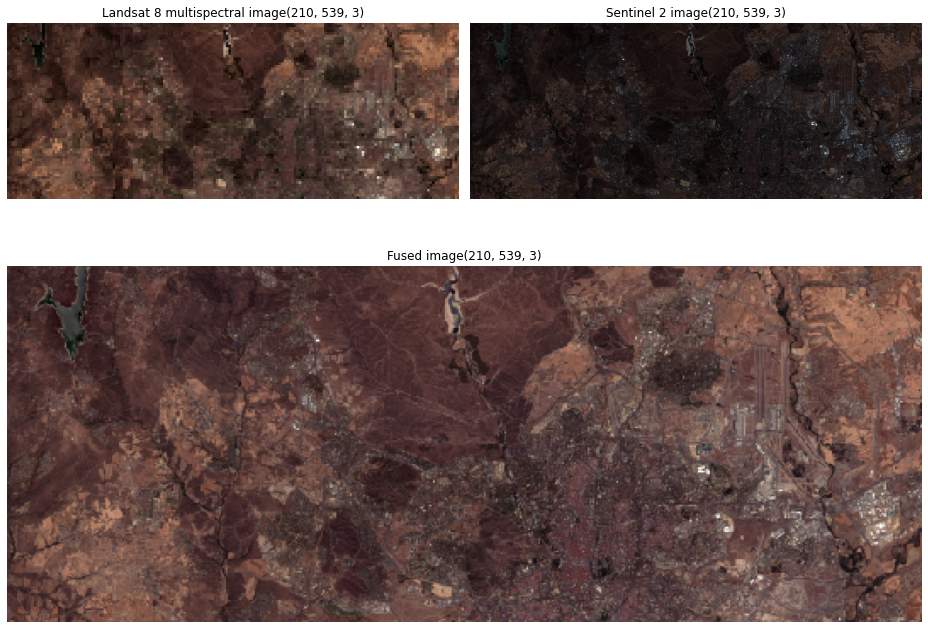

In [12]:
# Fused image normalization
vis_fus = np.copy(img_fus)
vis_fus[:,:,0] = ((vis_fus[:,:,0]-np.amin(vis_fus[:,:,0]))/(np.amax(vis_fus[:,:,0])-np.amin(vis_fus[:,:,0])))*255
vis_fus[:,:,1] = ((vis_fus[:,:,1]-np.amin(vis_fus[:,:,1]))/(np.amax(vis_fus[:,:,1])-np.amin(vis_fus[:,:,1])))*255
vis_fus[:,:,2] = ((vis_fus[:,:,2]-np.amin(vis_fus[:,:,2]))/(np.amax(vis_fus[:,:,2])-np.amin(vis_fus[:,:,2])))*255
vis_fus = vis_fus.astype(int)

# Container creation, to fit the plots, with gridspec layout from matplotlib
fig = plt.figure(figsize=(13, 10))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# Add the Landsat 8 image
ax0 = fig.add_subplot(spec[0,0])
ax0.imshow(L8_xs)
ax0.set_title("Landsat 8 multispectral image" + str(L8_xs.shape))
ax0.axis('off')

# Add the Sentinel 2 image
ax1 = fig.add_subplot(spec[0,1])
ax1.imshow(S2_xs)
ax1.set_title("Sentinel 2 image"  + str(S2_xs.shape))
ax1.axis('off')

# Add the fused image
ax2 = fig.add_subplot(spec[1,:])
ax2.imshow(vis_fus)
ax2.set_title("Fused image" + str(img_fus.shape))
ax2.axis('off')

plt.tight_layout()

# Quality measure of the fused image
The quality of the fused image will be measured with the spectral quality (using Spectral ERGAS) and the spatial quality (using spatial ERGAS).

### Definition of spectral ERGAS

The spectral quality of the fused images is evaluated through the ERGAS index (Wald 2000) defined by the equation:

(5)$$ ERGAS_{spectral}\ =100\frac{h}{l}\sqrt{\frac{1}{N_{Bands}}\sum_{i\ =1}^{N_{Bands}}\left(\frac{{RMSE}^2\left({Band}_i\right)}{{MULTI}_i^2}\right)}$$

where _h_ and _l_ represent the spatial resolution of the PAN and MULTI images, respectively, N<sub>Bands</sub> is the number of bands of the fused image, MULTI<sub>i</sub> is the radiance value of the _i_ th band of the MULTI image and RMSE is defined as:

(6)$$ RMSE\left({Band}_i\right)\ =\ \frac{1}{NP}\sqrt{\sum_{k\ =\ i}^{NP}\left({MULTI}_i\left(k\right)\ -\ {FUS}_i\left(k\right)\right)^2} $$

where _NP_ is the number of pixels of the fused image and FUS<sub>i</sub> represents the _i_ th band of the fused image.

In [13]:
def spectral_ERGAS(img_origND, img_fusND, ratio, coef_rad, n_band):

    # Initialize variables
    img_orig = np.empty(img_origND.shape)
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    mean_img_orig = np.empty(n_band)
    mean_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)

    for i in range(n_band):
        # Digital image to radiance
        img_orig[:,:,i] = img_origND[:,:,i]*coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i]*coef_rad[i]

        # Mean value of the radiances per band
        mean_img_orig[i] = img_orig[:,:,i].mean()
        mean_img_fus[i] = img_fus[:,:,i].mean()

        # Diference between the multispectral image and the fused image
        dif_imgs[:,:,i] = img_orig[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_orig[i] - mean_img_fus[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i]/(mean_img_orig[i]**2)

    # Spectral ergas
    return 100*(ratio**2)*math.sqrt(razon_img_fus.mean())

### Definition of spatial ERGAS
Given that in the definition of the ERGAS (5), only spectral characteristics of the source images to be fused were considered, Lillo-Saavedra et al. (2005) proposed a new index with the objective of evaluating the spatial quality of these images. This new index is inspired by the spectral ERGAS and has been named spatial ERGAS. In its definition, a spatial RMSE has been included, which is defined as:

(7)$$RMSE\left({Band}_i\right)\ =\ \frac{1}{NP}\sqrt{\sum_{k\ =\ i}^{NP}\left({PAN}_i\left(k\right)\ -\ {FUS}_i\left(k\right)\right)^2}$$

where PAN<sub>i</sub> is the image obtained by adjusting the histogram of the original PAN image to the histogram of the _i_ th band of the MULTI image. So, the spatial ERGAS is defined by the equation:

(8)$$ERGAS_{spatial}\ =100\frac{h}{l}\sqrt{\frac{1}{N_{Bands}}\sum_{i\ =1}^{N_{Bands}}\left(\frac{{RMSE}^2\left({Band}_i\right)}{{PAN}_i^2}\right)}$$

In [14]:
def spatial_ERGAS(img_panND, img_fusND, ratio, coef_rad, n_band):
    
    # Initialize variables
    img_panc = np.empty(img_fusND.shape)
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    img_pan_hist = np.empty(img_fusND.shape)
    mean_img_pan = np.empty(n_band)
    mean_img_multi = np.empty(n_band) # multi es la imagen fusionada
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)

    for i in range(n_band):
        # Digital image to radiance
        img_panc[:,:,i] = img_panND[:,:,i]*coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i]*coef_rad[i]

        # Mean value of the radiances per band
        mean_img_pan[i] = img_panc[:,:,i].mean()
        mean_img_multi[i] = img_fus[:,:,i].mean()

        # Histogram of the panchromatic image
        delta_media = mean_img_multi[i] - mean_img_pan[i]
        img_pan_hist[:,:,i] = img_panc[:,:,i] + delta_media

        # Mean value of the panchromatic image histogram
        mean_img_pan[i] = img_pan_hist[:,:,i].mean()

        # Diference between the panchromatic image and the fused image
        dif_imgs[:,:,i] = img_pan_hist[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_pan[i] - mean_img_multi[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i]/(mean_img_pan[i]**2)

    # Spatial ERGAS
    return 100*(ratio**2)*math.sqrt(razon_img_fus.mean())

### SPECTRAL AND SPATIAL ERGAS OF THE FUSED IMAGE
Run the following cell to get the spectral and the spatial ERGAS of the fused image.

In [15]:
# ERGAS
ERGAS_X = spectral_ERGAS(img_L8_xs, img_fus, 1/3, [1,1,1], 3)
ERGAS_S = spatial_ERGAS(matched, img_fus, 1/3, [1,1,1], 3)

# Display ERGAS on a table
tab = tt.Texttable()
headings = ['Espectral ERGAS','Spatial ERGAS']
tab.header(headings)
tab.add_row((ERGAS_X, ERGAS_S))
print(tab.draw())

+-----------------+---------------+
| Espectral ERGAS | Spatial ERGAS |
+=================+===============+
| 3.859           | 0.788         |
+-----------------+---------------+


# Download images

* Download Landsat 8 multispectral TIFF file

In [16]:
img_l8_path = os.path.join(out_dir, 'landsat_multi.tif')

with rasterio.open(
    img_l8_path,
    'w',
    driver='GTiff',
    height=img_L8_xs.shape[0],
    width=img_L8_xs.shape[1],
    count=img_L8_xs.shape[2],
    dtype=img_L8_xs.dtype,
    crs='+proj=latlong',
    transform=r_landsat_B2.transform,
) as dst:
    dst.write(reshape_as_raster(img_L8_xs))
    
print('Downloaded Landsat 8 image in >> ', img_l8_path)

Downloaded Landsat 8 image in >>  C:\Users\Jiahao\Downloads\landsat_multi.tif


* Download Sentinel 2 TIFF file

In [17]:
img_s2_path = os.path.join(out_dir, 'sentinel_multi.tif')
with rasterio.open(
    img_s2_path,
    'w',
    driver='GTiff',
    height=img_S2_xs.shape[0],
    width=img_S2_xs.shape[1],
    count=img_S2_xs.shape[2],
    dtype=img_S2_xs.dtype,
    crs='+proj=latlong',
    transform=r_sentinel_B2.transform,
) as dst:
    dst.write(reshape_as_raster(img_S2_xs))
    
print('Downloaded Sentinel 2 image in >> ', img_s2_path)

Downloaded Sentinel 2 image in >>  C:\Users\Jiahao\Downloads\sentinel_multi.tif


* Download fused image TIFF file

In [18]:
img_fus_path = os.path.join(out_dir, 'img_fus_multi_multi.tif')

with rasterio.open(
    img_fus_path,
    'w',
    driver='GTiff',
    height=img_fus.shape[0],
    width=img_fus.shape[1],
    count=img_fus.shape[2],
    dtype=img_fus.dtype,
    crs='+proj=latlong',
    transform=r_landsat_B2.transform,
) as dst:
    dst.write(reshape_as_raster(img_fus))
    
print('Downloaded fused image in >> ', img_fus_path)

Downloaded fused image in >>  C:\Users\Jiahao\Downloads\img_fus_multi_multi.tif
